In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys, os
import json
import torch.nn as nn  
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
import torch.optim as optim

import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from utils import ImageShow,draw_size_acc,one_hot
from utils import confusion_matrix,metrics_scores,pff
from model import FixCapsNet

In [3]:
# Settings.
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
img_title = "NCT-CRC"#"HAM10000"#"COVID-19"#
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}
#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

In [4]:
def get_data(trans_size='224'):
    global test_dataset,train_loader,val_loader,test_loader,train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([#transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([#transforms.Resize((228, 228)),
                                   #transforms.CenterCrop((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_size, trans_size)),
                                   transforms.CenterCrop((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "datasets","NCT-CRC")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)

    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)

    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [5]:
BatchSize = 128#128#188
V_size = 64
T_size = 64
learning_rate = 0.123
train_doc = "train"
val_doc = "val"
test_doc = "test"
nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.


In [6]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 224
mode='DS'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 104, 104]             975
            Conv2d-2          [-1, 128, 52, 52]             512
         LayerNorm-3          [-1, 128, 52, 52]             256
              ReLU-4          [-1, 128, 52, 52]               0
FractionalMaxPool2d-5          [-1, 128, 20, 20]               0
            Conv2d-6          [-1, 128, 20, 20]          16,384
       BatchNorm2d-7          [-1, 128, 20, 20]             256
         Hardswish-8          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
             ReLU-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [7]:
dsize = (1, 3, 224, 224)
input_data = torch.randn(dsize).to(device)
pff(m_name="FixCaps",model=network,inputes=input_data)

  Model   | Params(M) | FLOPs(G) | FPS
----------|-----------|----------|-----
FixCaps |    0.13   |   0.02   | 129.3


In [8]:
network.Convolution

Sequential(
  (0): Conv2d(3, 3, kernel_size=(18, 18), stride=(2, 2), groups=3)
  (1): Conv2d(3, 128, kernel_size=(1, 1), stride=(2, 2))
  (2): LayerNorm()
  (3): ReLU(inplace=True)
  (4): FractionalMaxPool2d()
)

In [9]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m Train Epoch:[{epoch}]{img_title} ==> Training \033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    # scaler = torch.cuda.amp.GradScaler()
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)
        # data, target =data.to(device), target_one_hot.to(device)
        # with torch.cuda.amp.autocast():
        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()        
        optimizer.step()
        optimizer.zero_grad()
        # scheduler.step()#AdamW            
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [10]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,test_evl_result,val_evl_result,evl_tmp_result,net_parameters
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and test_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

    diag_sum = torch.sum(evl_tmp_result.diagonal())
    all_sum = torch.sum(evl_tmp_result) 
    test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
    print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")
    
    if split == 'val':
        val_acc_list.append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), save_PATH)
            torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
        print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
    else:
        test_acc_list.append(test_acc)
        if test_acc > eval_acc:
            eval_acc = test_acc
            test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
            torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
            torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
        print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")  

In [11]:
#create store
try:
    print(f"suf:{suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf:{suf}")   
if os.path.exists(f'./tmp/{img_title}/{suf}'):
    print (f'Store: "./tmp/{img_title}/{suf}"')
else:
    # !mkdir -p "./tmp/{img_title}/{suf}" #First
    os.mkdir(f"./tmp/{img_title}/{suf}")
iter_path = f'./tmp/{img_title}/{suf}/train_{img_title}_{suf}.pth'
save_PATH = f'./tmp/{img_title}/{suf}/best_{img_title}_{suf}.pth'
last_path = f'./tmp/{img_title}/{suf}/last_{img_title}_{suf}.pth'
print(save_PATH)

suf:0703_092723
./tmp/NCT-CRC/0703_092723/best_NCT-CRC_0703_092723.pth


In [12]:
num_epochs = 128

In [13]:
# learning_rate = 0.123
def_betas=(0.9, 0.999)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(network.parameters(), lr=learning_rate, weight_decay=0.01)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

#base_momentum=0.85, max_momentum=0.95, div_factor=25.0, final_div_factor=10000.0,
# scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate,
#                         steps_per_epoch=len(train_loader),
#                         epochs=num_epochs)

In [14]:
for epoch in range(1, num_epochs + 1): 
    train(epoch)
    test('val')

print('Finished Training')

 Train Epoch:[1]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.24993,ACC:0.48375
[626/626] Loss0.21154,ACC:0.59019
Train Epoch:[1] Loss:0.27082,Acc:0.59034,Best_train:0.59034
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:65.363%
Best_val:[65.363%]
 Train Epoch:[2]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.20434,ACC:0.75607
[626/626] Loss0.12860,ACC:0.76893
Train Epoch:[2] Loss:0.16515,Acc:0.76912,Best_train:0.76912
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.139%
Best_val:[93.139%]
 Train Epoch:[3]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.10948,ACC:0.81312
[626/626] Loss0.09785,ACC:0.81631
Train Epoch:[3] Loss:0.13516,Acc:0.81651,Best_train:0.81651
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:94.988%
Best_val:[94.988%]
 Train Epoch:[4]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09946,ACC:0.83986
[626/626] Loss0.11131,ACC:0.84154
Train Epoch:[4] Loss:0.11643,Acc:0.84175,Best_train:0.84175
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.019%
Best_val:[96.019%]
 Train Epoch:[5]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.10415,ACC:0.85793
[626/626] Loss0.07662,ACC:0.85971
Train Epoch:[5] Loss:0.10395,Acc:0.85993,Best_train:0.85993
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.494%
Best_val:[96.494%]
 Train Epoch:[6]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08387,ACC:0.86454
[626/626] Loss0.12378,ACC:0.86232
Train Epoch:[6] Loss:0.10154,Acc:0.86254,Best_train:0.86254
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:95.736%
Best_val:[96.494%]
 Train Epoch:[7]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.11488,ACC:0.86442
[626/626] Loss0.12684,ACC:0.86485
Train Epoch:[7] Loss:0.10078,Acc:0.86507,Best_train:0.86507
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:95.817%
Best_val:[96.494%]
 Train Epoch:[8]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09718,ACC:0.86167
[626/626] Loss0.10718,ACC:0.86123
Train Epoch:[8] Loss:0.10375,Acc:0.86145,Best_train:0.86507
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.332%
Best_val:[96.494%]
 Train Epoch:[9]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.10261,ACC:0.85296
[626/626] Loss0.13473,ACC:0.85896
Train Epoch:[9] Loss:0.10664,Acc:0.85918,Best_train:0.86507
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:90.361%
Best_val:[96.494%]
 Train Epoch:[10]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.11025,ACC:0.86020
[626/626] Loss0.07531,ACC:0.86566
Train Epoch:[10] Loss:0.10206,Acc:0.86588,Best_train:0.86588
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:95.726%
Best_val:[96.494%]
 Train Epoch:[11]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09619,ACC:0.86097
[626/626] Loss0.12229,ACC:0.86684
Train Epoch:[11] Loss:0.10229,Acc:0.86705,Best_train:0.86705
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:71.678%
Best_val:[96.494%]
 Train Epoch:[12]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08843,ACC:0.88404
[626/626] Loss0.07484,ACC:0.88560
Train Epoch:[12] Loss:0.08891,Acc:0.88582,Best_train:0.88582
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.564%
Best_val:[96.494%]
 Train Epoch:[13]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07092,ACC:0.89756
[626/626] Loss0.07959,ACC:0.89985
Train Epoch:[13] Loss:0.07947,Acc:0.90007,Best_train:0.90007
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:87.734%
Best_val:[96.494%]
 Train Epoch:[14]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05688,ACC:0.90947
[626/626] Loss0.06825,ACC:0.91175
Train Epoch:[14] Loss:0.07149,Acc:0.91198,Best_train:0.91198
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.322%
Best_val:[97.322%]
 Train Epoch:[15]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04552,ACC:0.91953
[626/626] Loss0.05312,ACC:0.92084
Train Epoch:[15] Loss:0.06575,Acc:0.92107,Best_train:0.92107
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.747%
Best_val:[97.747%]
 Train Epoch:[16]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05625,ACC:0.92128
[626/626] Loss0.08839,ACC:0.92201
Train Epoch:[16] Loss:0.06473,Acc:0.92224,Best_train:0.92224
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.484%
Best_val:[97.747%]
 Train Epoch:[17]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08260,ACC:0.92267
[626/626] Loss0.05449,ACC:0.92242
Train Epoch:[17] Loss:0.06502,Acc:0.92265,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.504%
Best_val:[97.747%]
 Train Epoch:[18]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08092,ACC:0.91524
[626/626] Loss0.07709,ACC:0.91454
Train Epoch:[18] Loss:0.07029,Acc:0.91477,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.575%
Best_val:[97.747%]
 Train Epoch:[19]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.10858,ACC:0.89442
[626/626] Loss0.08694,ACC:0.89909
Train Epoch:[19] Loss:0.08233,Acc:0.89931,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.413%
Best_val:[97.747%]
 Train Epoch:[20]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09624,ACC:0.90697
[626/626] Loss0.06958,ACC:0.90684
Train Epoch:[20] Loss:0.07575,Acc:0.90706,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.423%
Best_val:[97.747%]
 Train Epoch:[21]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.14147,ACC:0.82493
[626/626] Loss0.08268,ACC:0.86034
Train Epoch:[21] Loss:0.10794,Acc:0.86055,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:89.957%
Best_val:[97.747%]
 Train Epoch:[22]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05418,ACC:0.91254
[626/626] Loss0.04312,ACC:0.89977
Train Epoch:[22] Loss:0.08130,Acc:0.90000,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.868%
Best_val:[97.868%]
 Train Epoch:[23]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06706,ACC:0.91504
[626/626] Loss0.06445,ACC:0.91782
Train Epoch:[23] Loss:0.06793,Acc:0.91805,Best_train:0.92265
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.181%
Best_val:[97.868%]
 Train Epoch:[24]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06376,ACC:0.92894
[626/626] Loss0.07530,ACC:0.92956
Train Epoch:[24] Loss:0.06027,Acc:0.92979,Best_train:0.92979
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.939%
Best_val:[97.939%]
 Train Epoch:[25]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09076,ACC:0.93520
[626/626] Loss0.04599,ACC:0.93439
Train Epoch:[25] Loss:0.05661,Acc:0.93463,Best_train:0.93463
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.484%
Best_val:[98.484%]
 Train Epoch:[26]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07154,ACC:0.93119
[626/626] Loss0.05863,ACC:0.93227
Train Epoch:[26] Loss:0.05800,Acc:0.93250,Best_train:0.93463
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.424%
Best_val:[98.484%]
 Train Epoch:[27]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05263,ACC:0.93585
[626/626] Loss0.04226,ACC:0.93580
Train Epoch:[27] Loss:0.05585,Acc:0.93604,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.494%
Best_val:[98.494%]
 Train Epoch:[28]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04450,ACC:0.93131
[626/626] Loss0.06704,ACC:0.93140
Train Epoch:[28] Loss:0.05929,Acc:0.93163,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.191%
Best_val:[98.494%]
 Train Epoch:[29]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05890,ACC:0.92332
[626/626] Loss0.03789,ACC:0.92626
Train Epoch:[29] Loss:0.06352,Acc:0.92649,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:92.715%
Best_val:[98.494%]
 Train Epoch:[30]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.09475,ACC:0.92315
[626/626] Loss0.07459,ACC:0.90261
Train Epoch:[30] Loss:0.08111,Acc:0.90283,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:78.933%
Best_val:[98.494%]
 Train Epoch:[31]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05001,ACC:0.91913
[626/626] Loss0.09621,ACC:0.92217
Train Epoch:[31] Loss:0.06631,Acc:0.92240,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:86.127%
Best_val:[98.494%]
 Train Epoch:[32]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07306,ACC:0.92969
[626/626] Loss0.04538,ACC:0.92910
Train Epoch:[32] Loss:0.06150,Acc:0.92933,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.222%
Best_val:[98.494%]
 Train Epoch:[33]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05588,ACC:0.93401
[626/626] Loss0.04339,ACC:0.93458
Train Epoch:[33] Loss:0.05713,Acc:0.93481,Best_train:0.93604
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:71.304%
Best_val:[98.494%]
 Train Epoch:[34]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03979,ACC:0.93635
[626/626] Loss0.07586,ACC:0.93792
Train Epoch:[34] Loss:0.05442,Acc:0.93816,Best_train:0.93816
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:81.085%
Best_val:[98.494%]
 Train Epoch:[35]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04905,ACC:0.94564
[626/626] Loss0.05692,ACC:0.94455
Train Epoch:[35] Loss:0.04921,Acc:0.94479,Best_train:0.94479
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.777%
Best_val:[98.777%]
 Train Epoch:[36]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05572,ACC:0.94584
[626/626] Loss0.04520,ACC:0.94647
Train Epoch:[36] Loss:0.04821,Acc:0.94671,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.697%
Best_val:[98.777%]
 Train Epoch:[37]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05639,ACC:0.94481
[626/626] Loss0.05713,ACC:0.94557
Train Epoch:[37] Loss:0.04851,Acc:0.94581,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.191%
Best_val:[98.777%]
 Train Epoch:[38]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05775,ACC:0.93905
[626/626] Loss0.06896,ACC:0.94069
Train Epoch:[38] Loss:0.05243,Acc:0.94093,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.868%
Best_val:[98.777%]
 Train Epoch:[39]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08353,ACC:0.93104
[626/626] Loss0.04988,ACC:0.92820
Train Epoch:[39] Loss:0.06196,Acc:0.92843,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.171%
Best_val:[98.777%]
 Train Epoch:[40]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07623,ACC:0.93538
[626/626] Loss0.06116,ACC:0.93424
Train Epoch:[40] Loss:0.05806,Acc:0.93448,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.05%
Best_val:[98.777%]
 Train Epoch:[41]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08307,ACC:0.93271
[626/626] Loss0.08197,ACC:0.93260
Train Epoch:[41] Loss:0.05885,Acc:0.93283,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:83.874%
Best_val:[98.777%]
 Train Epoch:[42]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06663,ACC:0.93772
[626/626] Loss0.06003,ACC:0.93570
Train Epoch:[42] Loss:0.05598,Acc:0.93594,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.201%
Best_val:[98.777%]
 Train Epoch:[43]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03640,ACC:0.94197
[626/626] Loss0.04531,ACC:0.94152
Train Epoch:[43] Loss:0.05221,Acc:0.94175,Best_train:0.94671
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:85.177%
Best_val:[98.777%]
 Train Epoch:[44]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04400,ACC:0.94876
[626/626] Loss0.04931,ACC:0.94800
Train Epoch:[44] Loss:0.04756,Acc:0.94823,Best_train:0.94823
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.211%
Best_val:[98.777%]
 Train Epoch:[45]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02709,ACC:0.95128
[626/626] Loss0.04022,ACC:0.95022
Train Epoch:[45] Loss:0.04457,Acc:0.95045,Best_train:0.95045
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.808%
Best_val:[98.808%]
 Train Epoch:[46]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05635,ACC:0.95055
[626/626] Loss0.05550,ACC:0.95156
Train Epoch:[46] Loss:0.04418,Acc:0.95180,Best_train:0.95180
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.707%
Best_val:[98.808%]
 Train Epoch:[47]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04788,ACC:0.95123
[626/626] Loss0.03100,ACC:0.95189
Train Epoch:[47] Loss:0.04397,Acc:0.95213,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.828%
Best_val:[98.828%]
 Train Epoch:[48]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06054,ACC:0.94037
[626/626] Loss0.03938,ACC:0.94350
Train Epoch:[48] Loss:0.05040,Acc:0.94374,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.656%
Best_val:[98.828%]
 Train Epoch:[49]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03441,ACC:0.94401
[626/626] Loss0.06725,ACC:0.94324
Train Epoch:[49] Loss:0.05146,Acc:0.94348,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.333%
Best_val:[98.828%]
 Train Epoch:[50]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07877,ACC:0.89097
[626/626] Loss0.07715,ACC:0.90881
Train Epoch:[50] Loss:0.07821,Acc:0.90904,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.302%
Best_val:[98.828%]
 Train Epoch:[51]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.07077,ACC:0.92944
[626/626] Loss0.03055,ACC:0.93196
Train Epoch:[51] Loss:0.05978,Acc:0.93219,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.584%
Best_val:[98.828%]
 Train Epoch:[52]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06367,ACC:0.93550
[626/626] Loss0.03553,ACC:0.93740
Train Epoch:[52] Loss:0.05528,Acc:0.93763,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.231%
Best_val:[98.828%]
 Train Epoch:[53]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05487,ACC:0.94561
[626/626] Loss0.03280,ACC:0.94340
Train Epoch:[53] Loss:0.05103,Acc:0.94364,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.504%
Best_val:[98.828%]
 Train Epoch:[54]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04720,ACC:0.94986
[626/626] Loss0.04187,ACC:0.94949
Train Epoch:[54] Loss:0.04668,Acc:0.94973,Best_train:0.95213
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.201%
Best_val:[98.828%]
 Train Epoch:[55]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04587,ACC:0.95080
[626/626] Loss0.04370,ACC:0.95196
Train Epoch:[55] Loss:0.04398,Acc:0.95220,Best_train:0.95220
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.212%
Best_val:[98.828%]
 Train Epoch:[56]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02937,ACC:0.95260
[626/626] Loss0.05883,ACC:0.95401
Train Epoch:[56] Loss:0.04335,Acc:0.95425,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.181%
Best_val:[98.828%]
 Train Epoch:[57]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03421,ACC:0.95500
[626/626] Loss0.04138,ACC:0.95271
Train Epoch:[57] Loss:0.04356,Acc:0.95295,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.828%
Best_val:[98.828%]
 Train Epoch:[58]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04236,ACC:0.94841
[626/626] Loss0.05009,ACC:0.94868
Train Epoch:[58] Loss:0.04706,Acc:0.94892,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.191%
Best_val:[98.828%]
 Train Epoch:[59]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04871,ACC:0.94581
[626/626] Loss0.05475,ACC:0.94557
Train Epoch:[59] Loss:0.05018,Acc:0.94581,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:85.177%
Best_val:[98.828%]
 Train Epoch:[60]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06995,ACC:0.93927
[626/626] Loss0.05357,ACC:0.93822
Train Epoch:[60] Loss:0.05597,Acc:0.93846,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.373%
Best_val:[98.828%]
 Train Epoch:[61]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05341,ACC:0.94194
[626/626] Loss0.26157,ACC:0.89053
Train Epoch:[61] Loss:0.08879,Acc:0.89075,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:69.415%
Best_val:[98.828%]
 Train Epoch:[62]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.19455,ACC:0.72993
[626/626] Loss0.11650,ACC:0.77647
Train Epoch:[62] Loss:0.17320,Acc:0.77666,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.655%
Best_val:[98.828%]
 Train Epoch:[63]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.08376,ACC:0.88683
[626/626] Loss0.07583,ACC:0.90048
Train Epoch:[63] Loss:0.08431,Acc:0.90071,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.231%
Best_val:[98.828%]
 Train Epoch:[64]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06071,ACC:0.93066
[626/626] Loss0.06312,ACC:0.93212
Train Epoch:[64] Loss:0.06080,Acc:0.93235,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.868%
Best_val:[98.828%]
 Train Epoch:[65]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04843,ACC:0.93807
[626/626] Loss0.04712,ACC:0.93947
Train Epoch:[65] Loss:0.05435,Acc:0.93971,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.636%
Best_val:[98.828%]
 Train Epoch:[66]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04673,ACC:0.94022
[626/626] Loss0.05659,ACC:0.94069
Train Epoch:[66] Loss:0.05339,Acc:0.94093,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.545%
Best_val:[98.828%]
 Train Epoch:[67]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03067,ACC:0.94219
[626/626] Loss0.04316,ACC:0.94176
Train Epoch:[67] Loss:0.05318,Acc:0.94199,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.464%
Best_val:[98.828%]
 Train Epoch:[68]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04420,ACC:0.93827
[626/626] Loss0.05038,ACC:0.94015
Train Epoch:[68] Loss:0.05413,Acc:0.94038,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.938%
Best_val:[98.828%]
 Train Epoch:[69]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05084,ACC:0.93655
[626/626] Loss0.05019,ACC:0.93606
Train Epoch:[69] Loss:0.05698,Acc:0.93630,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.908%
Best_val:[98.828%]
 Train Epoch:[70]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06041,ACC:0.93760
[626/626] Loss0.05319,ACC:0.93844
Train Epoch:[70] Loss:0.05520,Acc:0.93867,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.413%
Best_val:[98.828%]
 Train Epoch:[71]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05114,ACC:0.94045
[626/626] Loss0.05152,ACC:0.93926
Train Epoch:[71] Loss:0.05467,Acc:0.93949,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:91.836%
Best_val:[98.828%]
 Train Epoch:[72]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06247,ACC:0.93957
[626/626] Loss0.05643,ACC:0.93977
Train Epoch:[72] Loss:0.05409,Acc:0.94001,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.04%
Best_val:[98.828%]
 Train Epoch:[73]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05117,ACC:0.94816
[626/626] Loss0.04975,ACC:0.94747
Train Epoch:[73] Loss:0.04814,Acc:0.94771,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.535%
Best_val:[98.828%]
 Train Epoch:[74]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03891,ACC:0.95118
[626/626] Loss0.06303,ACC:0.95069
Train Epoch:[74] Loss:0.04566,Acc:0.95093,Best_train:0.95425
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.222%
Best_val:[98.828%]
 Train Epoch:[75]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04294,ACC:0.95400
[626/626] Loss0.04909,ACC:0.95439
Train Epoch:[75] Loss:0.04263,Acc:0.95462,Best_train:0.95462
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.111%
Best_val:[98.828%]
 Train Epoch:[76]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06312,ACC:0.95422
[626/626] Loss0.04017,ACC:0.95469
Train Epoch:[76] Loss:0.04242,Acc:0.95492,Best_train:0.95492
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.08%
Best_val:[98.828%]
 Train Epoch:[77]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02748,ACC:0.95639
[626/626] Loss0.04412,ACC:0.95542
Train Epoch:[77] Loss:0.04209,Acc:0.95566,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:97.888%
Best_val:[98.828%]
 Train Epoch:[78]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03435,ACC:0.95255
[626/626] Loss0.05039,ACC:0.95153
Train Epoch:[78] Loss:0.04541,Acc:0.95177,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:98.151%
Best_val:[98.828%]
 Train Epoch:[79]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05360,ACC:0.94826
[626/626] Loss0.06954,ACC:0.94803
Train Epoch:[79] Loss:0.04809,Acc:0.94827,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.261%
Best_val:[98.828%]
 Train Epoch:[80]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05541,ACC:0.94352
[626/626] Loss0.05139,ACC:0.94426
Train Epoch:[80] Loss:0.05079,Acc:0.94450,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.494%
Best_val:[98.828%]
 Train Epoch:[81]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04061,ACC:0.94501
[626/626] Loss0.10197,ACC:0.94438
Train Epoch:[81] Loss:0.05093,Acc:0.94461,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.16%
Best_val:[98.828%]
 Train Epoch:[82]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03477,ACC:0.94514
[626/626] Loss0.03579,ACC:0.94526
Train Epoch:[82] Loss:0.04974,Acc:0.94550,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:88.694%
Best_val:[98.828%]
 Train Epoch:[83]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03410,ACC:0.94898
[626/626] Loss0.04013,ACC:0.95029
Train Epoch:[83] Loss:0.04593,Acc:0.95053,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:92.543%
Best_val:[98.828%]
 Train Epoch:[84]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03947,ACC:0.95377
[626/626] Loss0.04002,ACC:0.95431
Train Epoch:[84] Loss:0.04285,Acc:0.95455,Best_train:0.95566
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.514%
Best_val:[98.828%]
 Train Epoch:[85]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03234,ACC:0.95794
[626/626] Loss0.04858,ACC:0.95734
Train Epoch:[85] Loss:0.04023,Acc:0.95758,Best_train:0.95758
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:95.382%
Best_val:[98.828%]
 Train Epoch:[86]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03809,ACC:0.95917
[626/626] Loss0.05589,ACC:0.95910
Train Epoch:[86] Loss:0.04047,Acc:0.95934,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:92.927%
Best_val:[98.828%]
 Train Epoch:[87]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02711,ACC:0.95677
[626/626] Loss0.04829,ACC:0.95708
Train Epoch:[87] Loss:0.04004,Acc:0.95732,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:91.078%
Best_val:[98.828%]
 Train Epoch:[88]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05760,ACC:0.95455
[626/626] Loss0.05088,ACC:0.95492
Train Epoch:[88] Loss:0.04268,Acc:0.95516,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:96.878%
Best_val:[98.828%]
 Train Epoch:[89]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03250,ACC:0.94851
[626/626] Loss0.05319,ACC:0.94863
Train Epoch:[89] Loss:0.04770,Acc:0.94887,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:92.159%
Best_val:[98.828%]
 Train Epoch:[90]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04597,ACC:0.94951
[626/626] Loss0.03571,ACC:0.94858
Train Epoch:[90] Loss:0.04753,Acc:0.94882,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.998%
Best_val:[98.828%]
 Train Epoch:[91]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05263,ACC:0.94858
[626/626] Loss0.03907,ACC:0.94858
Train Epoch:[91] Loss:0.04825,Acc:0.94882,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:82.884%
Best_val:[98.828%]
 Train Epoch:[92]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06184,ACC:0.94878
[626/626] Loss0.04079,ACC:0.94249
Train Epoch:[92] Loss:0.05309,Acc:0.94273,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:83.247%
Best_val:[98.828%]
 Train Epoch:[93]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05335,ACC:0.94933
[626/626] Loss0.04110,ACC:0.95193
Train Epoch:[93] Loss:0.04450,Acc:0.95216,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:93.291%
Best_val:[98.828%]
 Train Epoch:[94]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03624,ACC:0.95610
[626/626] Loss0.04531,ACC:0.95659
Train Epoch:[94] Loss:0.04120,Acc:0.95683,Best_train:0.95934
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:84.763%
Best_val:[98.828%]
 Train Epoch:[95]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04474,ACC:0.96046
[626/626] Loss0.04124,ACC:0.96003
Train Epoch:[95] Loss:0.03847,Acc:0.96027,Best_train:0.96027
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:75.912%
Best_val:[98.828%]
 Train Epoch:[96]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04665,ACC:0.96124
[626/626] Loss0.02191,ACC:0.96040
Train Epoch:[96] Loss:0.03857,Acc:0.96064,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:81.934%
Best_val:[98.828%]
 Train Epoch:[97]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04176,ACC:0.95884
[626/626] Loss0.05090,ACC:0.96014
Train Epoch:[97] Loss:0.03852,Acc:0.96038,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:83.914%
Best_val:[98.828%]
 Train Epoch:[98]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03968,ACC:0.95694
[626/626] Loss0.02084,ACC:0.95702
Train Epoch:[98] Loss:0.04097,Acc:0.95726,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:86.743%
Best_val:[98.828%]
 Train Epoch:[99]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05700,ACC:0.95295
[626/626] Loss0.04122,ACC:0.95268
Train Epoch:[99] Loss:0.04459,Acc:0.95291,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:95.352%
Best_val:[98.828%]
 Train Epoch:[100]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05293,ACC:0.95008
[626/626] Loss0.05570,ACC:0.95045
Train Epoch:[100] Loss:0.04636,Acc:0.95069,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:74.396%
Best_val:[98.828%]
 Train Epoch:[101]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.06929,ACC:0.95163
[626/626] Loss0.05197,ACC:0.94969
Train Epoch:[101] Loss:0.04667,Acc:0.94993,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:61.241%
Best_val:[98.828%]
 Train Epoch:[102]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04170,ACC:0.95225
[626/626] Loss0.02798,ACC:0.95281
Train Epoch:[102] Loss:0.04485,Acc:0.95305,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:91.957%
Best_val:[98.828%]
 Train Epoch:[103]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04425,ACC:0.95562
[626/626] Loss0.03734,ACC:0.95492
Train Epoch:[103] Loss:0.04248,Acc:0.95516,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:79.842%
Best_val:[98.828%]
 Train Epoch:[104]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03609,ACC:0.95782
[626/626] Loss0.04126,ACC:0.95887
Train Epoch:[104] Loss:0.03928,Acc:0.95911,Best_train:0.96064
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:77.428%
Best_val:[98.828%]
 Train Epoch:[105]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04325,ACC:0.96236
[626/626] Loss0.05434,ACC:0.96181
Train Epoch:[105] Loss:0.03689,Acc:0.96205,Best_train:0.96205
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:76.074%
Best_val:[98.828%]
 Train Epoch:[106]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02259,ACC:0.96224
[626/626] Loss0.02370,ACC:0.96155
Train Epoch:[106] Loss:0.03649,Acc:0.96179,Best_train:0.96205
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:76.983%
Best_val:[98.828%]
 Train Epoch:[107]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02872,ACC:0.96288
[626/626] Loss0.03197,ACC:0.96209
Train Epoch:[107] Loss:0.03689,Acc:0.96233,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:75.811%
Best_val:[98.828%]
 Train Epoch:[108]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05397,ACC:0.95867
[626/626] Loss0.03279,ACC:0.95885
Train Epoch:[108] Loss:0.03920,Acc:0.95909,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:70.466%
Best_val:[98.828%]
 Train Epoch:[109]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05315,ACC:0.95642
[626/626] Loss0.05365,ACC:0.95699
Train Epoch:[109] Loss:0.04192,Acc:0.95723,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:79.165%
Best_val:[98.828%]
 Train Epoch:[110]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05156,ACC:0.95193
[626/626] Loss0.02498,ACC:0.95236
Train Epoch:[110] Loss:0.04521,Acc:0.95260,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:75.195%
Best_val:[98.828%]
 Train Epoch:[111]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03987,ACC:0.94649
[626/626] Loss0.03281,ACC:0.94936
Train Epoch:[111] Loss:0.04810,Acc:0.94959,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:74.093%
Best_val:[98.828%]
 Train Epoch:[112]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03921,ACC:0.95310
[626/626] Loss0.03883,ACC:0.95339
Train Epoch:[112] Loss:0.04413,Acc:0.95363,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:85.794%
Best_val:[98.828%]
 Train Epoch:[113]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05456,ACC:0.95709
[626/626] Loss0.03386,ACC:0.95687
Train Epoch:[113] Loss:0.04133,Acc:0.95711,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:76.437%
Best_val:[98.828%]
 Train Epoch:[114]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04835,ACC:0.96044
[626/626] Loss0.03430,ACC:0.96018
Train Epoch:[114] Loss:0.03873,Acc:0.96042,Best_train:0.96233
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:79.266%
Best_val:[98.828%]
 Train Epoch:[115]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.02638,ACC:0.96431
[626/626] Loss0.03102,ACC:0.96305
Train Epoch:[115] Loss:0.03643,Acc:0.96329,Best_train:0.96329
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:75.417%
Best_val:[98.828%]
 Train Epoch:[116]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05282,ACC:0.96306
[626/626] Loss0.03539,ACC:0.96332
Train Epoch:[116] Loss:0.03608,Acc:0.96356,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:77.822%
Best_val:[98.828%]
 Train Epoch:[117]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04520,ACC:0.96296
[626/626] Loss0.02644,ACC:0.96276
Train Epoch:[117] Loss:0.03616,Acc:0.96300,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:75.407%
Best_val:[98.828%]
 Train Epoch:[118]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05215,ACC:0.96096
[626/626] Loss0.04277,ACC:0.96084
Train Epoch:[118] Loss:0.03851,Acc:0.96108,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:76.993%
Best_val:[98.828%]
 Train Epoch:[119]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03451,ACC:0.95649
[626/626] Loss0.04469,ACC:0.95679
Train Epoch:[119] Loss:0.04200,Acc:0.95703,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:70.678%
Best_val:[98.828%]
 Train Epoch:[120]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05815,ACC:0.95457
[626/626] Loss0.05074,ACC:0.95376
Train Epoch:[120] Loss:0.04408,Acc:0.95400,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:40.184%
Best_val:[98.828%]
 Train Epoch:[121]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04199,ACC:0.95258
[626/626] Loss0.03512,ACC:0.95204
Train Epoch:[121] Loss:0.04551,Acc:0.95228,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:87.734%
Best_val:[98.828%]
 Train Epoch:[122]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03678,ACC:0.95515
[626/626] Loss0.04595,ACC:0.95547
Train Epoch:[122] Loss:0.04288,Acc:0.95571,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:82.429%
Best_val:[98.828%]
 Train Epoch:[123]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.05129,ACC:0.95854
[626/626] Loss0.03912,ACC:0.95769
Train Epoch:[123] Loss:0.04045,Acc:0.95793,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:85.349%
Best_val:[98.828%]
 Train Epoch:[124]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04607,ACC:0.96181
[626/626] Loss0.03430,ACC:0.96111
Train Epoch:[124] Loss:0.03733,Acc:0.96135,Best_train:0.96356
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:65.242%
Best_val:[98.828%]
 Train Epoch:[125]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03814,ACC:0.96473
[626/626] Loss0.03314,ACC:0.96419
Train Epoch:[125] Loss:0.03541,Acc:0.96444,Best_train:0.96444
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:69.122%
Best_val:[98.828%]
 Train Epoch:[126]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.04416,ACC:0.96249
[626/626] Loss0.03470,ACC:0.96283
Train Epoch:[126] Loss:0.03559,Acc:0.96307,Best_train:0.96444
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:74.891%
Best_val:[98.828%]
 Train Epoch:[127]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03648,ACC:0.96406
[626/626] Loss0.02649,ACC:0.96454
Train Epoch:[127] Loss:0.03494,Acc:0.96479,Best_train:0.96479
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:78.65%
Best_val:[98.828%]
 Train Epoch:[128]NCT-CRC ==> Training  ...


  0%|          | 0/626 [00:00<?, ?it/s]

[313/626] Loss0.03849,ACC:0.96179
[626/626] Loss0.06376,ACC:0.96096
Train Epoch:[128] Loss:0.03775,Acc:0.96120,Best_train:0.96479
NCT-CRC ==> val ...


  0%|          | 0/155 [00:00<?, ?it/s]

val_Acc:65.06%
Best_val:[98.828%]
Finished Training


In [15]:
show.conclusion(opt="val",img_title=img_title)

=================Conclusion====================
Dataset:[NCT-CRC]
Best_Epoch [47]
[Val] ACC:98.83%.


In [16]:
network.load_state_dict(torch.load(save_PATH))

for k in range(51,64):
    T_size = k
    print(f"T_size:{k}")
    for i in range(224,235):
        get_data(i)
        print(f"size:{i}")
        for j in range(3):
            test()
            if dict_imgSize.get(i) is None or dict_imgSize[i] < test_acc:
                dict_imgSize[i] = test_acc

                if dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc
                    
            elif dict_batch.get(k) is None or dict_batch[k] < test_acc:
                    dict_batch[k] = test_acc    

T_size:41
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[98.549%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[98.659%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[98.659%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[98.689%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[98.779%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[98.779%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[98.779%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[98.779%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/244 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.02%]
T_size:42
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.439%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.339%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.519%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.529%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.579%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.569%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.409%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/238 [00:00<?, ?it/s]

test_Acc:98.489%
Best_eval:[99.02%]
T_size:43
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/233 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.02%]
T_size:44
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.02%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.02%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/228 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.1%]
T_size:45
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.469%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/223 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
T_size:46
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/218 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.1%]
T_size:47
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/213 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
T_size:48
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.529%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.379%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.449%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.509%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.579%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.629%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/209 [00:00<?, ?it/s]

test_Acc:98.569%
Best_eval:[99.1%]
T_size:49
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.439%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.499%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.539%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.569%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.629%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.489%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.559%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/204 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.1%]
T_size:50
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.529%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/200 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.1%]
T_size:51
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/196 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
T_size:52
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/193 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
T_size:53
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.1%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.1%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.15%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.15%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.15%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.15%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.15%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.15%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.16%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/189 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
T_size:54
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.419%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.519%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.549%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.589%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.599%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.629%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/186 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
T_size:55
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/182 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
T_size:56
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/179 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
T_size:57
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/176 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
T_size:58
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/173 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
T_size:59
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/170 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
T_size:60
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.649%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.629%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.729%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.679%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.769%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/167 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
T_size:61
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.889%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/164 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
T_size:62
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.659%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.749%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.829%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.779%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.719%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.819%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.929%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.859%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.909%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.669%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.619%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.689%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.639%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.839%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.609%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.709%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/162 [00:00<?, ?it/s]

test_Acc:98.699%
Best_eval:[99.16%]
T_size:63
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:224
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.759%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.849%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:225
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:226
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:227
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:228
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.16%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.14%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:229
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:230
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:231
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.16%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:232
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.16%
Best_eval:[99.16%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.22%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:233
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:234
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
size:235
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]


In [17]:
show.conclusion(img_title=img_title) 
sorted(dict_imgSize.items(), key=lambda x: x[1] ,reverse=True)[0:15]

=================Conclusion====================
Dataset:[NCT-CRC]
Best_Epoch [819]
[Test] ACC:99.22%.


[(232, 99.21960830688477),
 (228, 99.15958046913147),
 (229, 99.15958046913147),
 (227, 99.14957284927368),
 (230, 99.14957284927368),
 (234, 99.14957284927368),
 (235, 99.12956357002258),
 (233, 99.10955429077148),
 (225, 99.0795373916626),
 (231, 99.06953573226929),
 (226, 99.04952645301819),
 (224, 98.88944625854492)]

In [18]:
sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9]

[(63, 99.21960830688477),
 (53, 99.15958046913147),
 (59, 99.10955429077148),
 (44, 99.09955263137817),
 (58, 99.08954501152039),
 (51, 99.04952645301819),
 (52, 99.04952645301819),
 (41, 99.0195095539093),
 (57, 99.0195095539093)]

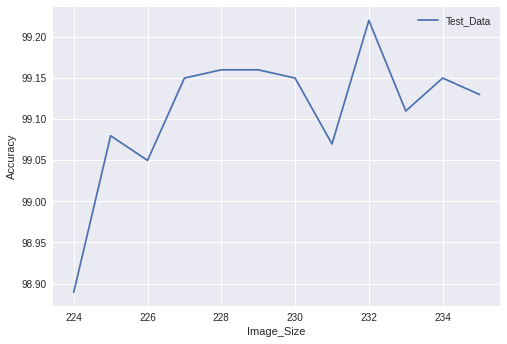

In [19]:
draw_size_acc(dict_imgSize,custom_path='./tmp',img_title=img_title,suf=suf)

In [20]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
|  ADI   |   0.9952  | 0.993  | 0.994 |          |
|  BACK  |   0.9934  |  1.0   | 0.997 |          |
|  DEB   |   0.9904  | 0.989  |  0.99 |          |
|  LYM   |   0.9948  | 0.994  | 0.994 |          |
|  MUC   |   0.9932  | 0.988  |  0.99 |          |
|  MUS   |   0.9933  | 0.993  | 0.993 |          |
|  NORM  |   0.9875  | 0.995  | 0.991 |          |
|  STR   |   0.9829  |  0.99  | 0.987 |          |
|  TUM   |   0.9965  | 0.988  | 0.992 |          |
| Total: |           |        |       |  0.9922  |
+--------+-----------+--------+-------+----------+


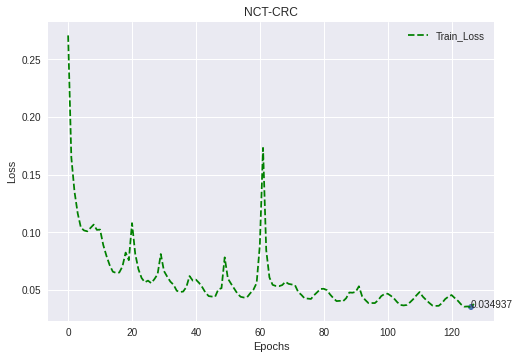

In [21]:
plt.clf()#clear photo
show.train(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

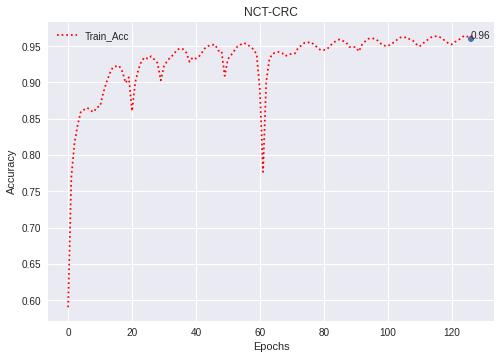

In [22]:
show.train(opt='Acc',write=True,custom_path='./tmp',img_title=img_title,suf=suf)

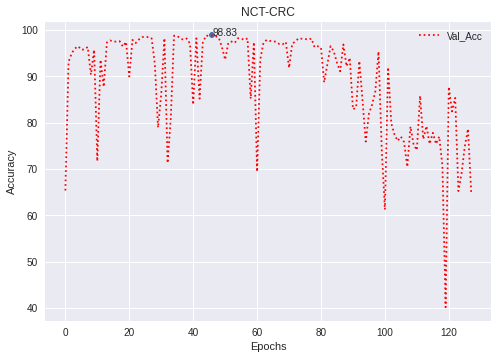

In [23]:
show.val(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

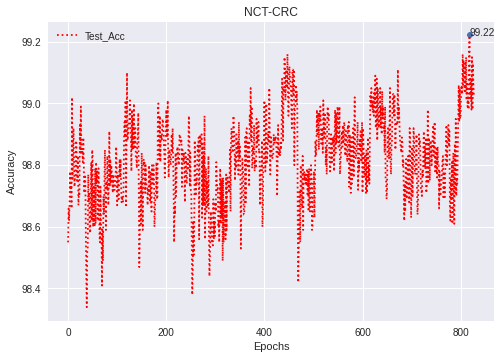

In [24]:
show.test(write=True,custom_path='./tmp',img_title=img_title,suf=suf)

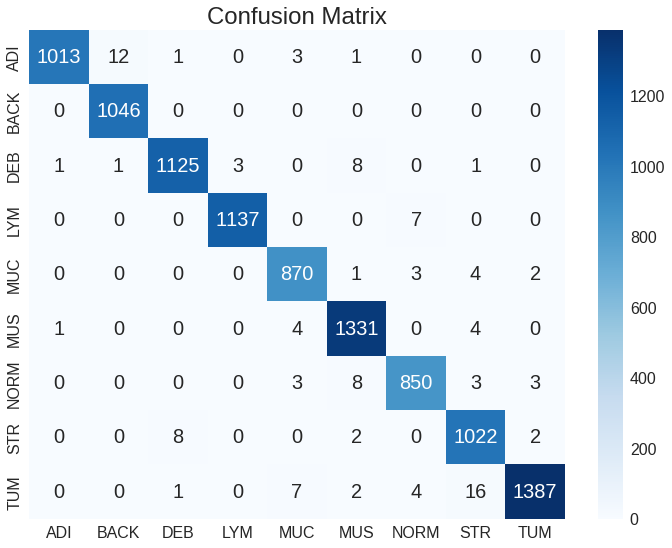

In [25]:
confusion_matrix(val_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [26]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
|  ADI   |   0.9952  | 0.993  | 0.994 |          |
|  BACK  |   0.9934  |  1.0   | 0.997 |          |
|  DEB   |   0.9904  | 0.989  |  0.99 |          |
|  LYM   |   0.9948  | 0.994  | 0.994 |          |
|  MUC   |   0.9932  | 0.988  |  0.99 |          |
|  MUS   |   0.9933  | 0.993  | 0.993 |          |
|  NORM  |   0.9875  | 0.995  | 0.991 |          |
|  STR   |   0.9829  |  0.99  | 0.987 |          |
|  TUM   |   0.9965  | 0.988  | 0.992 |          |
| Total: |           |        |       |  0.9922  |
+--------+-----------+--------+-------+----------+


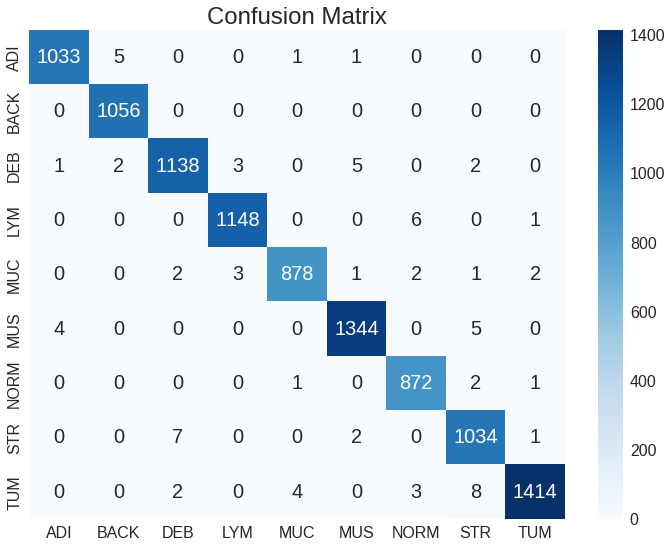

In [27]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)

In [28]:
# #save
s0 = np.array(train_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_acc_{suf}.npy', s0)
s1 = np.array(train_loss_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_train_loss_{suf}.npy', s1)
s2 = np.array(val_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_val_acc_{suf}.npy', s2)
s3 = np.array(test_acc_list)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_test_acc_{suf}.npy', s2)
s4 = np.array(dict_batch)
np.save(f'./tmp/{img_title}/{suf}/{img_title}_dict_batch_{suf}.npy', s2)

In [29]:
torch.cuda.memory.empty_cache()

In [42]:
network.load_state_dict(torch.load(save_PATH))
dict_batch ={}
dict_img = {}
for j in range(63,64):
    print(f"size:{j}")
    T_size = j

    for i in range(224,256):      
        get_data(i)
        for k in range(5):
            test()
            if dict_img.get(i) is None or dict_img[i] < test_acc:
                dict_img[i] = test_acc

                if dict_batch.get(j) is None or dict_batch[j] < test_acc:
                    dict_batch[j] = test_acc

size:63
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.869%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.809%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.799%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.789%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.739%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.879%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.14%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.919%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.939%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.899%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.14%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.22%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.18%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.19%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.17%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.18%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.14%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.19%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.22%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.27%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.22%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.27%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.2%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.17%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.1%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.16%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.18%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.21%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.14%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.989%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.12%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.07%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.05%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.13%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.11%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.16%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.08%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.949%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.04%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.03%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.979%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.09%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.02%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.15%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.27%]
Using 9 classes.
using 80108 images for training, 9897 images for validation, 9995 images for testing.
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.969%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:98.959%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.01%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.0%
Best_eval:[99.27%]
NCT-CRC ==> test ...


  0%|          | 0/159 [00:00<?, ?it/s]

test_Acc:99.06%
Best_eval:[99.27%]


In [43]:
show.conclusion(img_title=img_title)
sorted(dict_batch.items(), key=lambda x: x[1], reverse=True)[0:9]

=================Conclusion====================
Dataset:[NCT-CRC]
Best_Epoch [1631]
[Test] ACC:99.27%.


[(63, 99.26963448524475)]

In [44]:
sorted(dict_img.items(), key=lambda x: x[1], reverse=True)[0:9]

[(246, 99.26963448524475),
 (247, 99.26963448524475),
 (241, 99.21960830688477),
 (249, 99.20960664749146),
 (243, 99.18959736824036),
 (244, 99.17958974838257),
 (248, 99.17958974838257),
 (252, 99.15958046913147),
 (254, 99.14957284927368)]

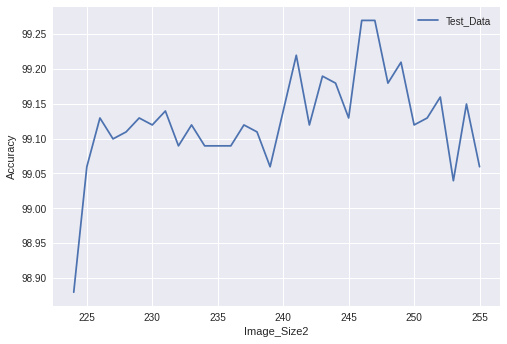

In [45]:
draw_size_acc(dict_img,custom_path='./tmp',fn='Image_Size2',img_title=img_title,suf=suf)

In [46]:
metrics_scores(test_evl_result,n_classes,cla_dict)

+--------+-----------+--------+-------+----------+
|  Type  | Precision | Recall |   F1  | Accuracy |
+--------+-----------+--------+-------+----------+
|  ADI   |   0.9952  | 0.997  | 0.996 |          |
|  BACK  |   0.9972  |  1.0   | 0.999 |          |
|  DEB   |   0.9965  | 0.988  | 0.992 |          |
|  LYM   |   0.9948  | 0.993  | 0.994 |          |
|  MUC   |   0.9932  | 0.987  |  0.99 |          |
|  MUS   |   0.9941  | 0.996  | 0.995 |          |
|  NORM  |   0.9853  | 0.995  |  0.99 |          |
|  STR   |   0.9801  |  0.99  | 0.985 |          |
|  TUM   |   0.9951  | 0.989  | 0.992 |          |
| Total: |           |        |       |  0.9927  |
+--------+-----------+--------+-------+----------+


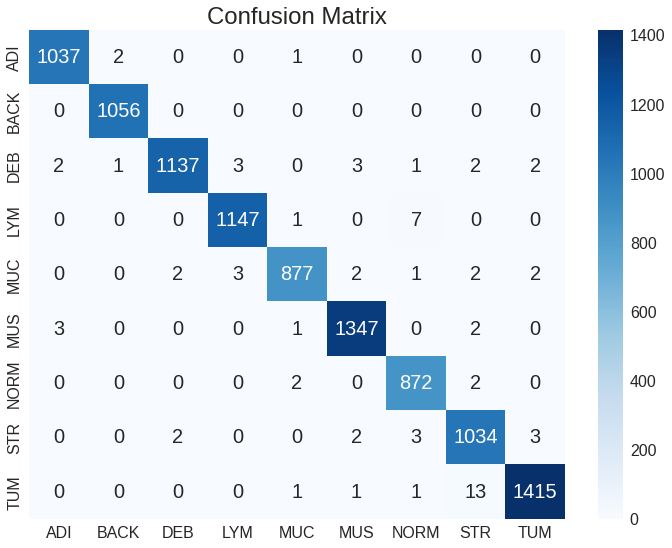

In [47]:
confusion_matrix(test_evl_result,n_classes,cla_dict,test_dataset,img_title=img_title,suf=suf)